# Introduction to Computational Science Assignment 1
### Koen Weverink - 14711983

<h1>Problem 1: Numerical integration of the basic model</h1>

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, root
from matplotlib.patches import Polygon

In [36]:
def coupled_odes(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [37]:
S0 = 0.9            # Initial susceptible population
I0 = 0.1            # Initial infected population
R0 = 1 - S0 - I0    # Initial recovered population
beta = 0.3
gamma = 0.1

# Solve the ODE's
t_span = (0, 100)
sol = solve_ivp(coupled_odes, t_span, [S0, I0, R0], args=(beta, gamma), t_eval=np.linspace(0, 100, 1000))

# Define the new parameters
beta2 = 0.3
gamma2 = 0.4

# Solve the ODE's
t_span = (0, 100)
sol2 = solve_ivp(coupled_odes, t_span, [S0, I0, R0], args=(beta2, gamma2), t_eval=np.linspace(0, 100, 1000))

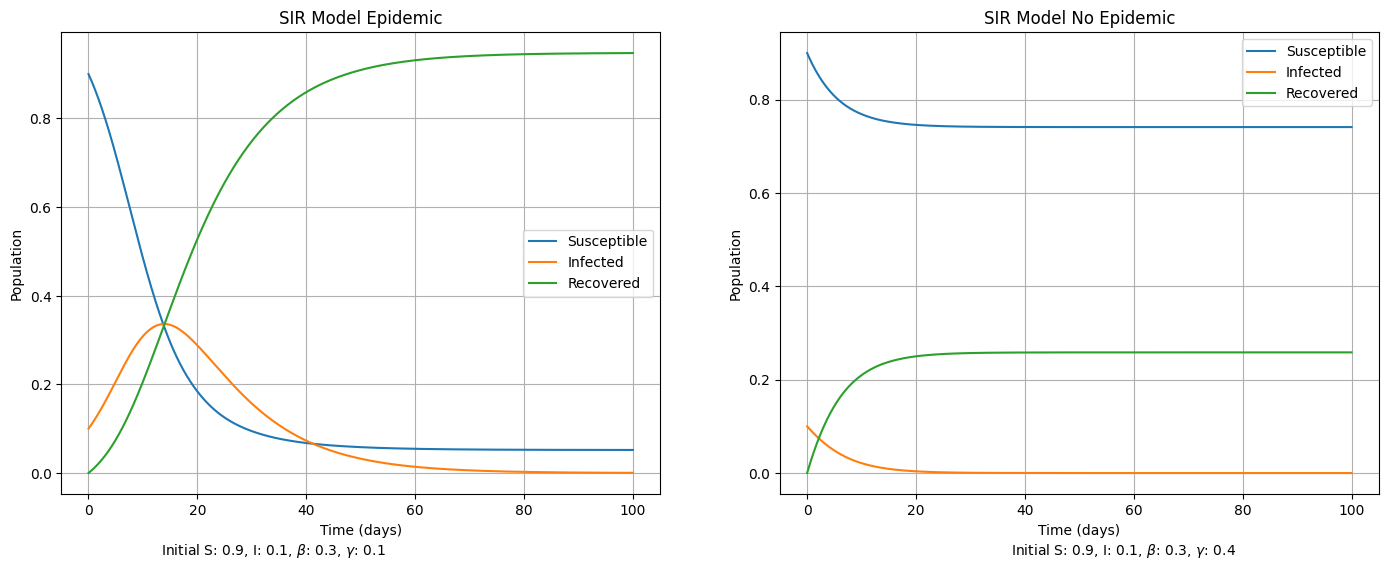

In [38]:
# Plot the results
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

ax1.plot(sol.t, sol.y[0], label='Susceptible')
ax1.plot(sol.t, sol.y[1], label='Infected')
ax1.plot(sol.t, sol.y[2], label='Recovered')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Population')
ax1.legend()
ax1.set_title('SIR Model Epidemic')
ax1.grid(True)

ax2.plot(sol2.t, sol2.y[0], label='Susceptible')
ax2.plot(sol2.t, sol2.y[1], label='Infected')
ax2.plot(sol2.t, sol2.y[2], label='Recovered')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Population')
ax2.legend()
ax2.set_title('SIR Model No Epidemic')
ax2.grid(True)

fig.text(0.25, 0.0001, fr'Initial S: {S0}, I: {I0}, $\beta$: {beta}, $\gamma$: {gamma}', 
            horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')

fig.text(0.75, 0.0001, fr'Initial S: {S0}, I: {I0}, $\beta$: {beta2}, $\gamma$: {gamma2}', 
            horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')
plt.show()

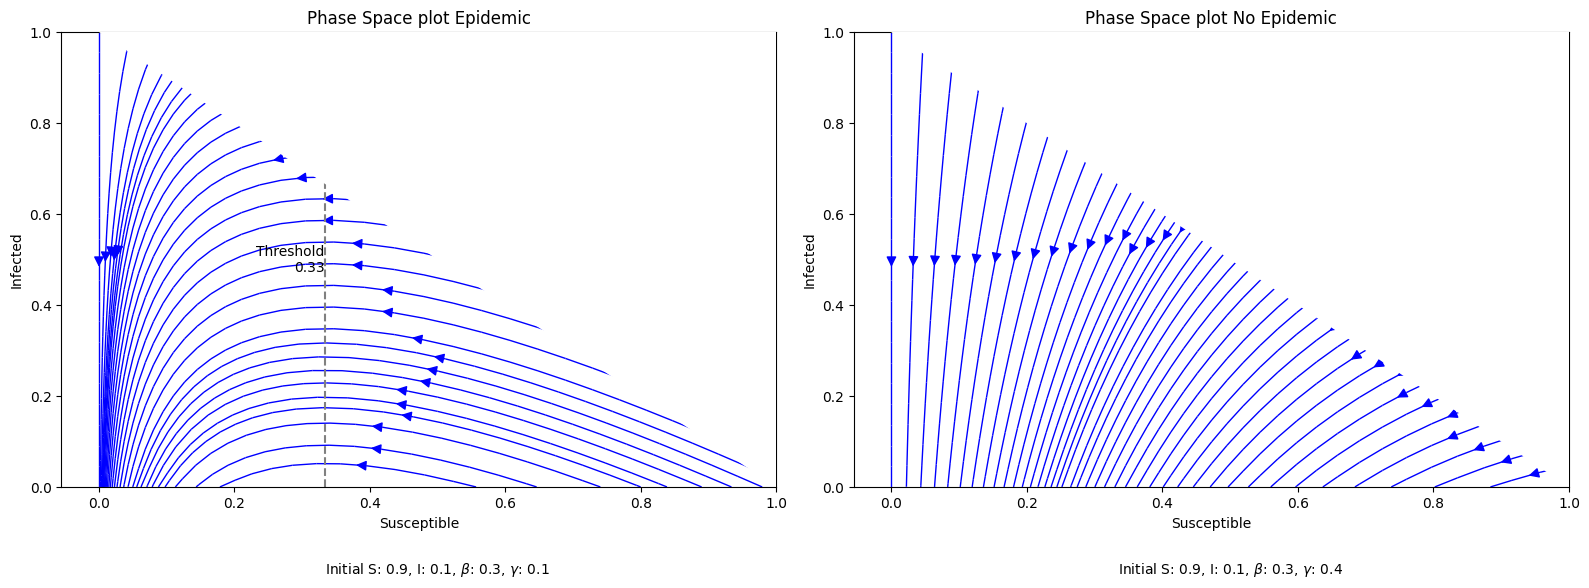

In [39]:
# Make a Phase Space plot of the above plots 
# Define a grid of points in the (x, y) plane
x = np.linspace(0, 1, 9)
y = np.linspace(0, 1, 9)

# Create a meshgrid from the x and y values
xx, yy = np.meshgrid(x, y)

# Calculate the third variable
zz = 1 - xx - yy

# Calculate vector field for the given parameters (beta, gamma) using coupled_odes function
uu, vv, _ = coupled_odes(0, [xx, yy, zz], beta, gamma)

# Calculate the magnitude of the vector field
mag = np.sqrt(uu**2 + vv**2)

# Set different parameters for a not-epidemic scenario (beta_en, gamma_en)
beta_en = 0.3
gamma_en = 0.4

# Calculate vector field for the second scenario using coupled_odes function
uu_en, vv_en, _ = coupled_odes(0, [xx, yy, zz], beta_en, gamma_en)

# Calculate the magnitude of the vector field for the second scenario
mag_en = np.sqrt(uu_en**2 + vv_en**2)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First subplot on the left: Streamplot for the epidemic scenario
ax1.streamplot(xx, yy, uu, vv, density=0.75, broken_streamlines=False, linewidth=1, color='blue', arrowsize=1.5)
ax1.set_title("Phase Space plot Epidemic")
ax1.set_xlabel("Susceptible")
ax1.set_ylabel("Infected")

# add parameters in figtext
ax1.text(0.5, -0.2, fr'Initial S: {S0}, I: {I0}, $\beta$: {beta}, $\gamma$: {gamma}', 
            horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')

# Add the threshold line to the first subplot
threshold = 1 / (beta / gamma)
ax1.axvline(threshold, label="Threshold", ls='--', color='grey')

# Add text for the threshold value on the left side
ax1.text(threshold, 0.5, f'Threshold\n{threshold:.2f}', 
         horizontalalignment='right', verticalalignment='center', fontsize=10, color='black')

# Add a polygon to highlight the feasible region in the first subplot
polygon = Polygon([[0, 1], [1, 1], [1, 0]], fill=True, edgecolor=None, facecolor='white', lw=2, zorder=10)
ax1.add_patch(polygon)

# Second subplot on the right: Streamplot for the non-epidemic scenario
ax2.streamplot(xx, yy, uu_en, vv_en, density=0.75, broken_streamlines=False, linewidth=1, color='blue', arrowsize=1.5)
ax2.set_title("Phase Space plot No Epidemic")
ax2.set_xlabel("Susceptible")
ax2.set_ylabel("Infected")

# Add a polygon to highlight the feasible region in the second subplot
polygon2 = Polygon([[0, 1], [1, 1], [1, 0]], fill=True, edgecolor=None, facecolor='white', lw=2, zorder=10)
ax2.add_patch(polygon2)

# add parameters in figtext
ax2.text(0.5, -0.2, fr'Initial S: {S0}, I: {I0}, $\beta$: {beta_en}, $\gamma$: {gamma_en}', 
            horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure with the two subplots
plt.show()

<h2>Fitting Historical Data to find beta and gamma</h2>

In [40]:
# Total students
total = 763

S0 = 762 / total    # Initial susceptible population
I0 = 1 / total      # Initial infected population
R0 = 1 - S0 - I0    # Initial recovered population

# Target array
target_array = np.array([1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5])

# Define the objective function to minimize (squared difference)
def objective(params):
    beta, gamma = params
    sol = solve_ivp(coupled_odes, (0, len(target_array)-1), [S0, I0, R0], args=(beta, gamma), t_eval=np.arange(len(target_array)))
    model_solution = sol.y[1]  # Infected population from the model
    return np.sum((model_solution * total - target_array)**2)

# Initial guess for beta and gamma
initial_guess = [0.2, 0.1]

# Perform the optimization to find beta and gamma
result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=((0, None), (0, None)))
optimal_beta, optimal_gamma = result.x

# Print the optimized parameters
print("Optimal beta:", optimal_beta)
print("Optimal gamma:", optimal_gamma)

Optimal beta: 1.6647601405531878
Optimal gamma: 0.44802704879725813


In [41]:
# Calculate the closest results using the optimal parameters
sol = solve_ivp(coupled_odes, (0, len(target_array)-1), [S0, I0, R0], args=(optimal_beta, optimal_gamma), t_eval=np.arange(len(target_array)))
closest_results = sol.y[1] * total

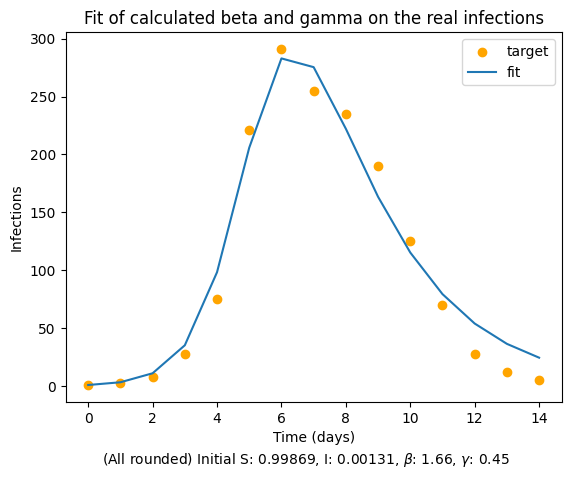

In [42]:
# Plot the fit over the target
plt.scatter(np.arange(0, 15, 1), target_array, color='orange', label='target')
plt.plot(closest_results, label='fit')
plt.xlabel("Time (days)")
plt.ylabel("Infections")
plt.title("Fit of calculated beta and gamma on the real infections")
plt.figtext(0.5, -0.03, fr'(All rounded) Initial S: {round((S0), 5)}, I: {round((I0), 5)}, $\beta$: {round((optimal_beta), 2)}, $\gamma$: {round((optimal_gamma), 2)}', 
            horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')
plt.legend()
plt.show()

<h2>Proposing a vaccination plan to prevent the epidemic</h2>

## Random vaccination

In [43]:
def coupled_odes_vac(t, y, beta, gamma, vaccination_rate):
    S, I, R = y
    dSdt = -beta * S * I - (vaccination_rate * S)
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I + (vaccination_rate * S)
    return [dSdt, dIdt, dRdt]

In [44]:
# Without vaccination
t_span = (0, 14)
vaccination_rate = 0
sol_novac = solve_ivp(coupled_odes_vac, (0, len(target_array)-1), [S0, I0, R0], args=(optimal_beta, optimal_gamma, vaccination_rate), t_eval=np.arange(len(target_array)))

In [45]:
# With vaccination when every timestep 5% of the school is vaccinated
t_span = (0, 14)
vaccination_rate = 0.05
sol_vac = solve_ivp(coupled_odes_vac, (0, len(target_array)-1), [S0, I0, R0], args=(optimal_beta, optimal_gamma, vaccination_rate), t_eval=np.arange(len(target_array)))

### Vaccination before disease hits the classroom, based on threshold


In [46]:
# Calculate R_0
R_0 = optimal_beta / optimal_gamma
print(f"Basic Reproduction Number (R₀): {R_0:.2f}")

# Calculate threshold 
threshold = 1 / R_0 
print(f"Threshold for Vaccination: {threshold:.4f}")

# Calculate how many people can be not vaccinated
new_S0 = S0 * threshold
print(f"Maximum Susceptible Individuals Without Vaccination: {new_S0 * total:.0f}")

new_R0 = 1 - new_S0 + I0
print(f"Initial Recovered Individuals Without Vaccination: {new_R0:.4f}")

t_span = (0, 14)
vaccination_rate = 0

# Solve the system of ODEs with vaccination
sol_prev = solve_ivp(coupled_odes_vac, (0, len(target_array)-1), [new_S0, I0, new_R0], args=(optimal_beta, optimal_gamma, vaccination_rate), t_eval=np.arange(len(target_array)))


Basic Reproduction Number (R₀): 3.72
Threshold for Vaccination: 0.2691
Maximum Susceptible Individuals Without Vaccination: 205
Initial Recovered Individuals Without Vaccination: 0.7325


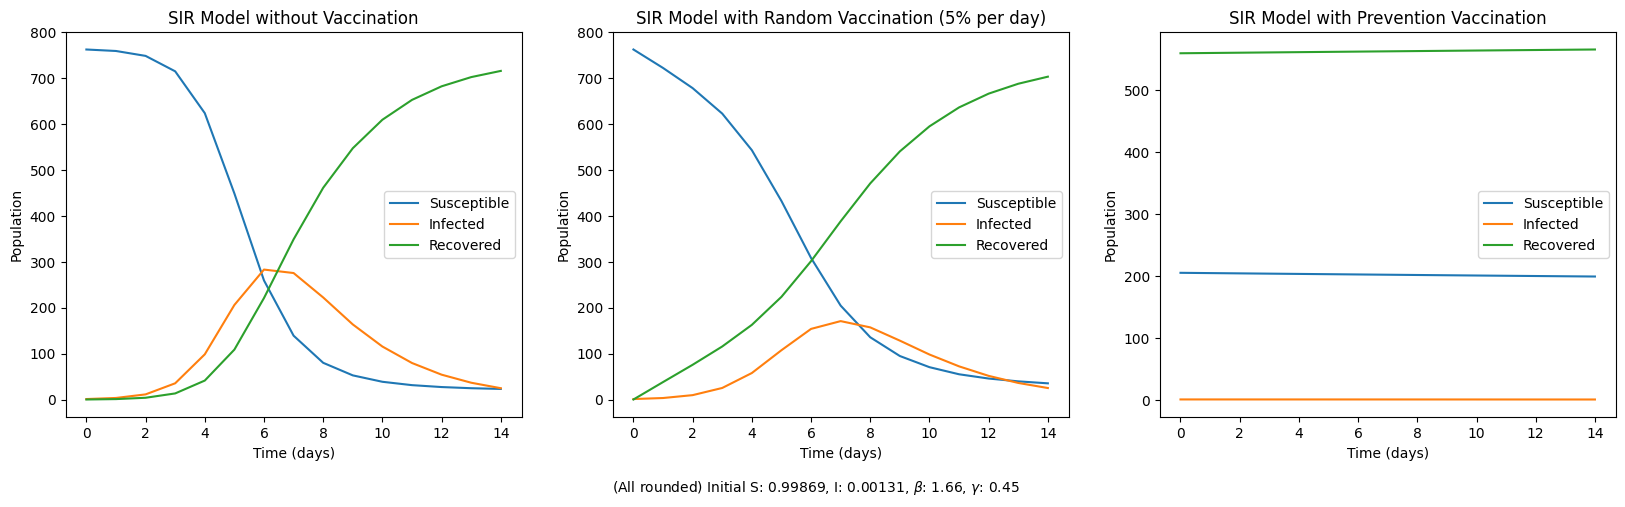

In [47]:
# Plotting
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot Without vaccination
ax1.plot(sol_novac.t, sol_novac.y[0] * total, label='Susceptible')
ax1.plot(sol_novac.t, sol_novac.y[1] * total, label='Infected')
ax1.plot(sol_novac.t, sol_novac.y[2] * total, label='Recovered')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Population')
ax1.set_title('SIR Model without Vaccination')
ax1.legend()

# Plot with 5% vaccinated each time step
ax2.plot(sol_vac.t, sol_vac.y[0] * total, label='Susceptible')
ax2.plot(sol_vac.t, sol_vac.y[1] * total, label='Infected')
ax2.plot(sol_vac.t, sol_vac.y[2] * total, label='Recovered')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Population')
ax2.set_title('SIR Model with Random Vaccination (5% per day)')
ax2.legend()

# Plot threshold strategy
ax3.plot(sol_prev.t, sol_prev.y[0] * total, label='Susceptible')
ax3.plot(sol_prev.t, sol_prev.y[1] * total, label='Infected')
ax3.plot(sol_prev.t, sol_prev.y[2] * total, label='Recovered')
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Population')
ax3.set_title('SIR Model with Prevention Vaccination')
ax3.legend()
# Add figtexts below the subplots
fig.text(0.5, -0.05, fr'(All rounded) Initial S: {round((S0), 5)}, I: {round((I0), 5)}, $\beta$: {round((optimal_beta), 2)}, $\gamma$: {round((optimal_gamma), 2)}', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')
plt.show()

<h1>Problem 2: Demography<h1>


### Adding Birth and Death rates

In [48]:
def coupled_odes_mu(t, y, mu, beta, gamma):
    S, I, R = y
    dSdt = mu - (beta * S * I) - (mu * S)
    dIdt = (beta * S * I) - (gamma * I) - (mu * I)
    dRdt = (gamma * I) - (mu * R)
    return [dSdt, dIdt, dRdt]

In [49]:
S0 = 0.99 # Initial susceptible population
I0 = 0.01 # Initial infected population
R0 = 0.0  # Initial recovered population
mu = 1/60
beta = 0.3
gamma = 0.1
t_span = (0,200)
dt = 0.1

sol = solve_ivp(coupled_odes_mu, t_span, [S0, I0, R0], args=(mu, beta, gamma), t_eval=np.linspace(0, 200, 1000))

In [50]:
# Define a function to find the fixed point
def find_fixed_point(mu, beta, gamma):
    # Initial guess for the fixed point
    initial_guess = [0.5, 0.1, 0.3]

    # Create a function that calculates the residuals (should be zero at the fixed point)
    def residuals(y):
        return coupled_odes_mu(0, y, mu, beta, gamma)

    # Use the root-finding method to find the fixed point
    result = root(residuals, initial_guess)

    fixed_point = result.x
    return fixed_point

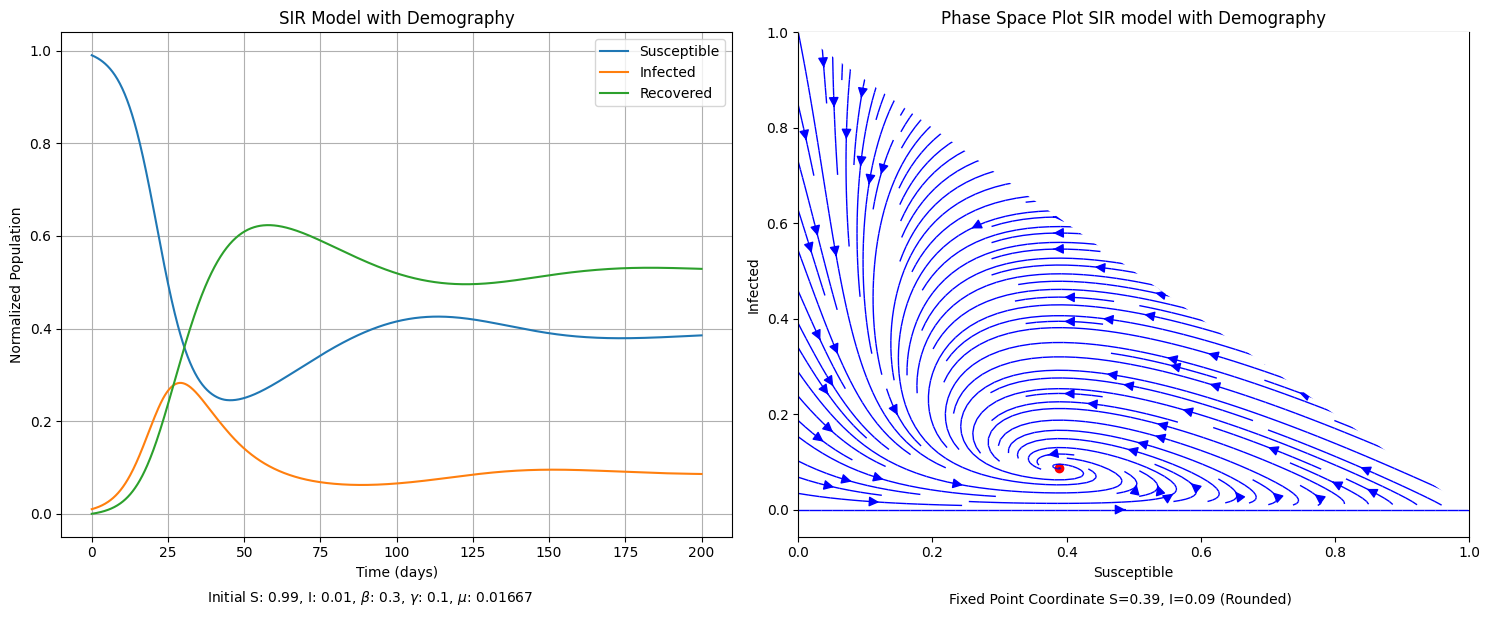

In [51]:
# Define a grid of points in the (x, y) plane
x = np.linspace(0, 1, 15)
y = np.linspace(0, 1, 15)

# Create a meshgrid from the x and y values
xx, yy = np.meshgrid(x, y)

# Calculate the third variable
zz = 1 - xx - yy

# Calculate vector field for the given parameters (mu, beta, gamma) using coupled_odes_mu function
uu, vv, _ = coupled_odes_mu(0, [xx, yy, zz], mu, beta, gamma)
mag = np.sqrt(uu**2 + vv**2)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the results of the SIR model with Demography
ax1.plot(sol.t, sol.y[0], label='Susceptible')
ax1.plot(sol.t, sol.y[1], label='Infected')
ax1.plot(sol.t, sol.y[2], label='Recovered')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Normalized Population')
ax1.set_title('SIR Model with Demography')
ax1.grid(True)
ax1.legend()

# Second subplot on the right: Streamplot for the SIR model with Demography
ax2.streamplot(xx, yy, uu, vv, density=2, linewidth=1, color='blue', arrowsize=1.5)
ax2.set_title("Phase Space Plot SIR model with Demography")
ax2.set_xlabel("Susceptible")
ax2.set_ylabel("Infected")

# Find and plot the fixed points
fixed_point = find_fixed_point(mu, beta, gamma)
S_fp, I_fp, R_fp = fixed_point
ax2.scatter(S_fp, I_fp, color='red', marker='o', label=f'Fixed Point S={round(S_fp, 2)}, I={round(I_fp, 2)}')

# Add a polygon to highlight the feasible region in the second subplot
polygon = Polygon([[0, 1], [1, 1], [1, 0]], fill=True, edgecolor=None, facecolor='white', lw=2, zorder=10)
ax2.add_patch(polygon)

# Add figtexts below the subplots
fig.text(0.25, -0.02, fr'Initial S: {round((S0), 5)}, I: {round((I0), 5)}, $\beta$: {round((beta), 2)}, $\gamma$: {round((gamma), 2)}, $\mu$: {round(mu, 5)}', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')

fig.text(0.75, -0.02, f'Fixed Point Coordinate S={round(S_fp, 2)}, I={round(I_fp, 2)} (Rounded)', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure with the two subplots
plt.show()


### Fourier analysis

In [52]:
# Perform Fourier analysis on I_values
fft_result = fft(sol.y[1])
freqs = np.fft.fftfreq(len(sol.y[1]), dt)
amplitudes = np.abs(fft_result)

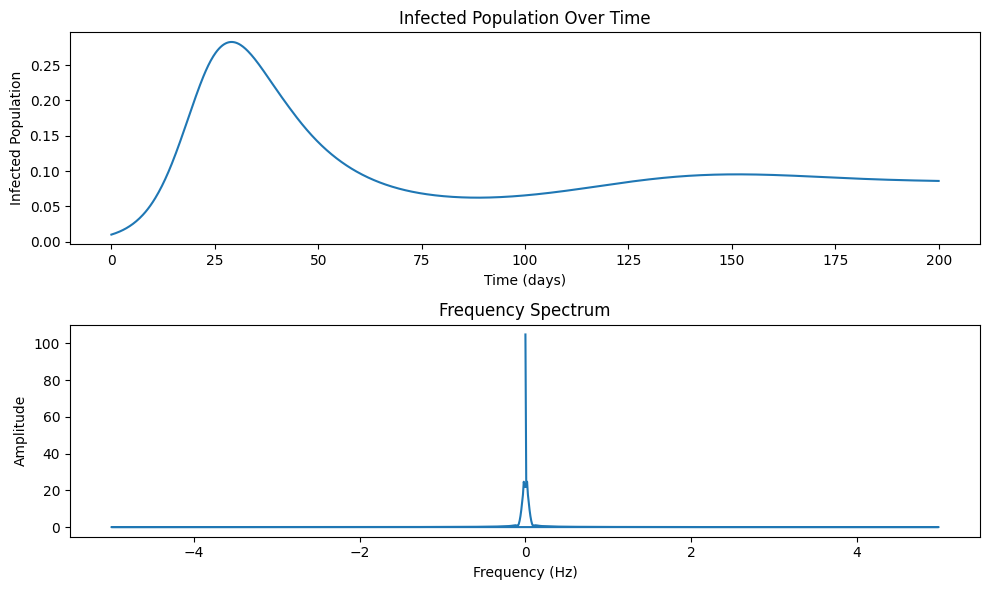

In [53]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the time evolution of the infected population
plt.subplot(2, 1, 1)
plt.plot(sol.t, sol.y[1])
plt.title("Infected Population Over Time")
plt.xlabel("Time (days)")
plt.ylabel("Infected Population")

# Plot the frequency spectrum
plt.subplot(2, 1, 2)
plt.plot(freqs, amplitudes)
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


### Introducing an infection induced mortality term

In [54]:
def coupled_odes_mortality_rate(t, y, p, mu, beta, gamma):
    S, I, R = y
    dSdt = mu - (beta * S * I) - (mu * S)
    dIdt = (beta * S * I) - (((gamma + mu) / (1 - p)) * I)
    dRdt = (gamma * I) - (mu * R)
    return [dSdt, dIdt, dRdt]

In [55]:
S0 = 0.99  # Initial susceptible population
I0 = 0.01 # Initial infected population
R0 = 0.0  # Initial recovered population
p = 0.3
mu = 1/60
beta = 0.3
gamma = 0.1

t_span = (0,200)
sol = solve_ivp(coupled_odes_mortality_rate, t_span, [S0, I0, R0], args=(p, mu, beta, gamma), t_eval=np.linspace(0, 200, 1000))

population = sol.y[0] + sol.y[1] + sol.y[2] 


In [56]:
# Define a function to find the fixed point
def find_fixed_point(p, mu, beta, gamma):
    # Initial guess for the fixed point
    initial_guess = [0.5, 0.1, 0.3]

    # Create a function that calculates the residuals (should be zero at the fixed point)
    def residuals(y):
        return coupled_odes_mortality_rate(0, y, p, mu, beta, gamma)

    # Use the root-finding method to find the fixed point
    result = root(residuals, initial_guess)

    fixed_point = result.x
    return fixed_point

In [57]:
# Calculate vector field for the given parameters (p, mu, beta, gamma) using coupled_odes_mortality_rate function
uu, vv, _ = coupled_odes_mortality_rate(0, [xx, yy, zz], p, mu, beta, gamma)
mag = np.sqrt(uu**2 + vv**2)

# Find and plot the fixed points
fixed_point = find_fixed_point(p, mu, beta, gamma)
S_fp, I_fp, R_fp = fixed_point

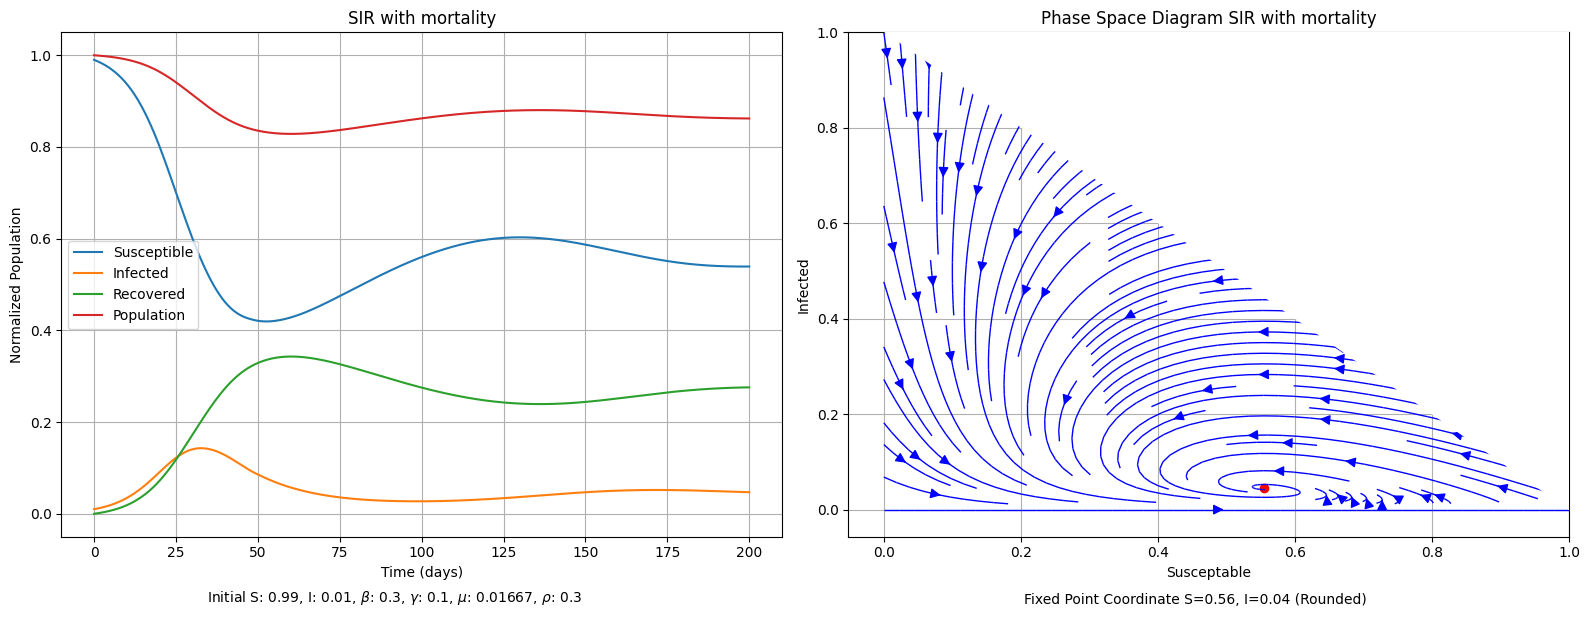

In [58]:
#Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the results
ax1.plot(sol.t, sol.y[0], label='Susceptible')
ax1.plot(sol.t, sol.y[1], label='Infected')
ax1.plot(sol.t, sol.y[2], label='Recovered')
ax1.plot(sol.t, population, label='Population')
ax1.grid(True)
ax1.set_title("SIR with mortality")
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Normalized Population')
ax1.legend()

# First subplot on the left
ax2.streamplot(xx, yy, uu, vv, density=1.5, linewidth=1, color='blue', arrowsize=1.5)
ax2.set_title("Phase Space Diagram SIR with mortality")
ax2.set_xlabel("Susceptable")
ax2.set_ylabel("Infected")
ax2.grid(True)

# Plot the fixed point
ax2.scatter(S_fp, I_fp, color='red', marker='o', label=f'Fixed Point S={round(S_fp, 2)}, I={round(I_fp, 2)}')

# Add the polygon to the first subplot
polygon = Polygon([[0, 1], [1, 1], [1, 0]], fill=True, edgecolor=None, facecolor='white', lw=2, zorder=10)
ax2.add_patch(polygon)

# Add figtexts below the subplots
fig.text(0.25, -0.02, fr'Initial S: {round((S0), 5)}, I: {round((I0), 5)}, $\beta$: {round((beta), 2)}, $\gamma$: {round((gamma), 2)}, $\mu$: {round(mu, 5)}, $\rho$: {p}', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')

fig.text(0.75, -0.02, f'Fixed Point Coordinate S={round(S_fp, 2)}, I={round(I_fp, 2)} (Rounded)', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

<h1>Problem 3: Variants of the SIR model<h1>


### SEIR Model

In [59]:
def SEIR_model(t, y, mu, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = mu - ((beta * I) + mu) * S
    dEdt = beta * S * I - (mu + sigma) * E
    dIdt = sigma * E - (mu + gamma) * I
    dRdt = gamma * I - mu * R
    return [dSdt, dEdt, dIdt, dRdt]

In [60]:
# Initial conditions
S0 = 0.9  # Initial susceptible fraction
E0 = 0.1  # Initial exposed fraction
I0 = 0.0  # Initial infectious fraction
R0 = 0.00  # Initial removed fraction

# Parameters
mu = 1/60
beta = 0.3   # Transmission rate
sigma = 0.1  # Rate of progression from exposed to infectious
gamma = 0.05 # Recovery or removal rate

In [61]:
# Time span
t_span = (0, 200)  # Simulation time from 0 to 200 days

# Solve the differential equations
sol = solve_ivp(SEIR_model, t_span, [S0, E0, I0, R0], args=(mu, beta, sigma, gamma), t_eval=np.linspace(0, 200, 1000))

# Higher sigma
sigma_new = 0.2
sol2 = solve_ivp(SEIR_model, t_span, [S0, E0, I0, R0], args=(mu, beta, sigma_new, gamma), t_eval=np.linspace(0, 200, 1000))

In [62]:
# Define a function to find the fixed point
def find_fixed_point(mu, beta, sigma, gamma):
    # Initial guess for the fixed point
    initial_guess = [0.5, 0.1, 0.1, 0.3]

    # Create a function that calculates the residuals (should be zero at the fixed point)
    def residuals(y):
        return SEIR_model(0, y, mu, beta, sigma, gamma)

    # Use the root-finding method to find the fixed point
    result = root(residuals, initial_guess)

    fixed_point = result.x
    return fixed_point

In [63]:
# Create a meshgrid for S and I
S_range = np.linspace(0, 1, 20)
I_range = np.linspace(0, 1, 20)
S_grid, I_grid = np.meshgrid(S_range, I_range)

# Calculate the corresponding dSdt and dIdt using the model
# sigma 1 
dSdt_grid, _, dIdt_grid, _ = SEIR_model(0, [S_grid, E0, I_grid, R0], mu, beta, sigma, gamma)

# sigma 2 
dSdt_grid2, _, dIdt_grid2, _ = SEIR_model(0, [S_grid, E0, I_grid, R0], mu, beta, sigma_new, gamma)

# Find and plot the fixed points
# sigma 1
fixed_point = find_fixed_point(mu, beta, sigma, gamma)
S_fp, E_pf, I_fp, R_fp = fixed_point

# sigma 2
fixed_point2 = find_fixed_point(mu, beta, sigma_new, gamma)
S_fp2, E_pf2, I_fp2, R_fp2 = fixed_point2


Text(0.5, 1.0, 'Phase-Space \n$\\beta$=0.3, $\\sigma$=0.2, $\\gamma$=0.05')

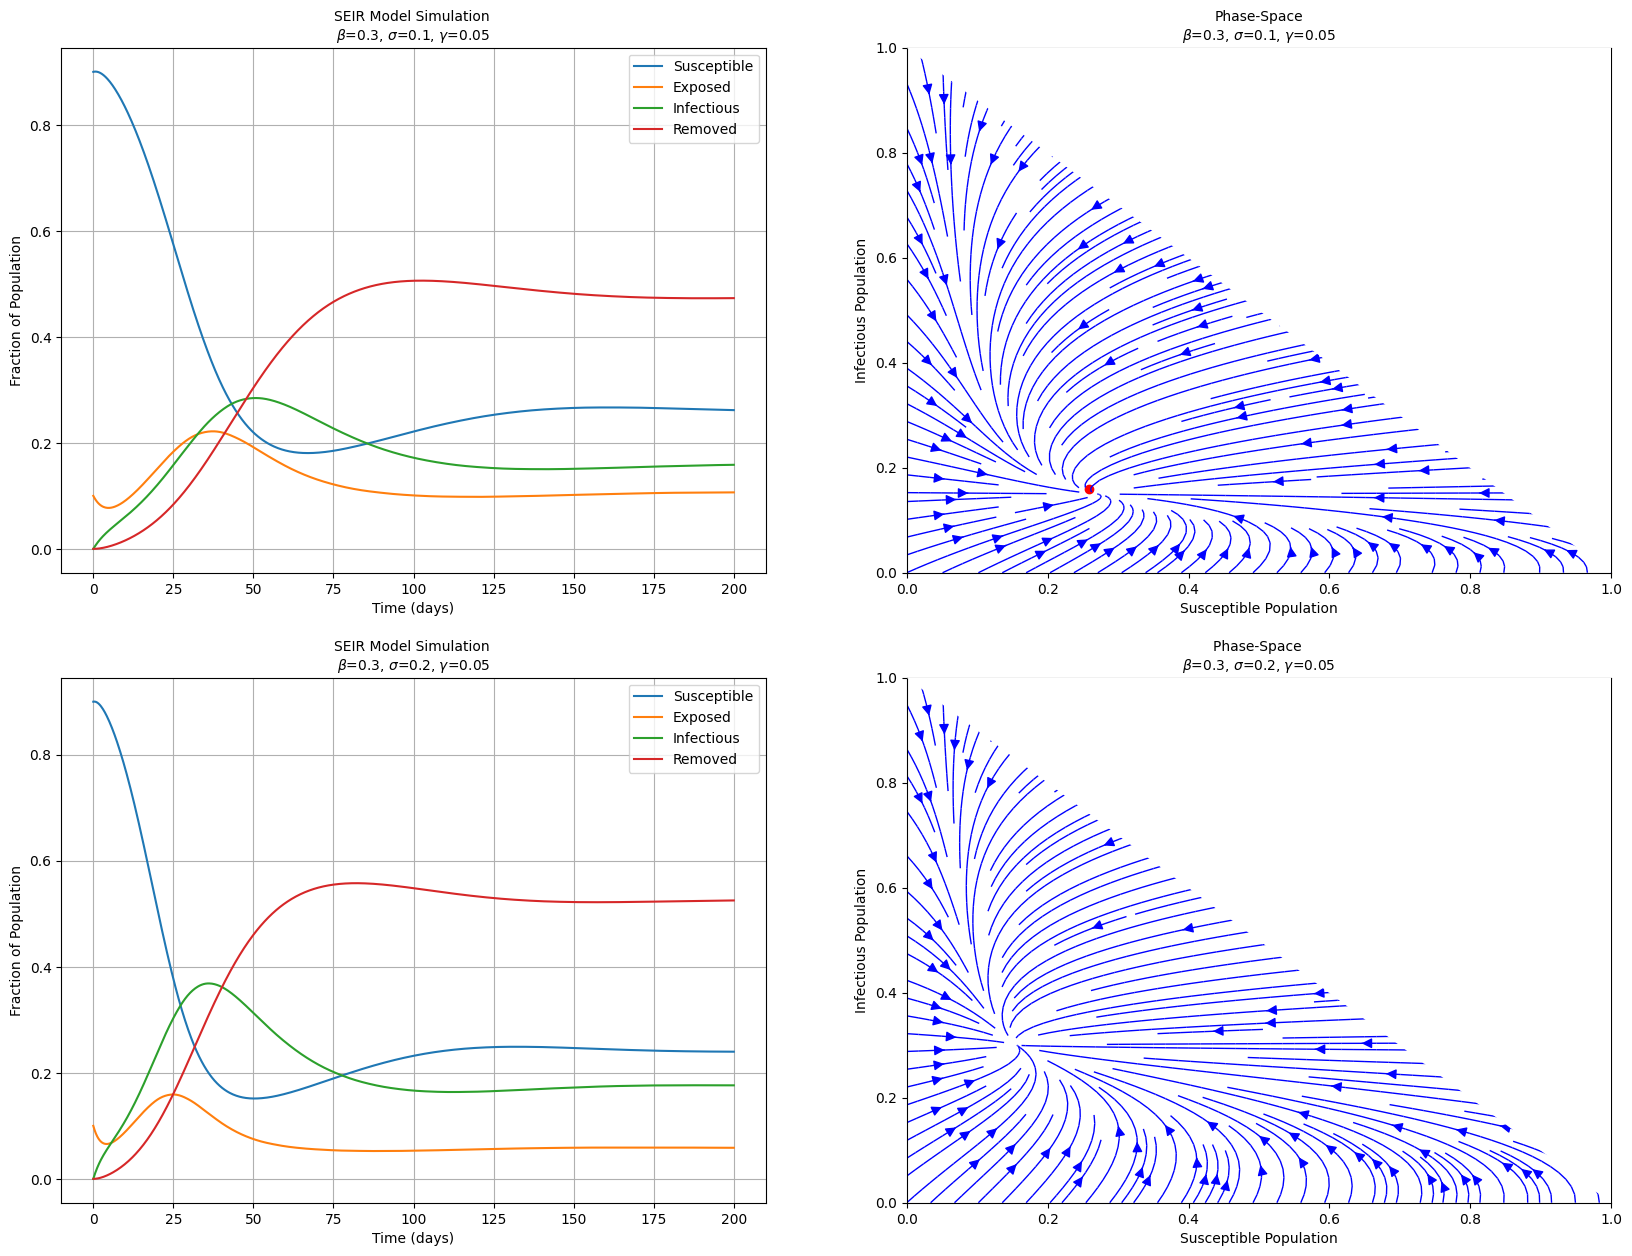

In [64]:
# Plot the results

#Create a figure with two subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

ax1.plot(sol.t, sol.y[0], label='Susceptible')
ax1.plot(sol.t, sol.y[1], label='Exposed')
ax1.plot(sol.t, sol.y[2], label='Infectious')
ax1.plot(sol.t, sol.y[3], label='Removed')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Fraction of Population')
ax1.grid(True)
ax1.legend()
ax1.set_title(fr"""SEIR Model Simulation 
$\beta$={beta}, $\sigma$={sigma}, $\gamma$={round(gamma, 2)}""", fontsize=10)

# Plot streamlines
ax2.streamplot(S_grid, I_grid, dSdt_grid, dIdt_grid, density=2, linewidth=1, color='blue', arrowsize=1.5)
ax2.set_title('SEIR Model Streamplot (S vs I)')
ax2.set_xlabel('Susceptible (S)')
ax2.set_ylabel('Infectious (I)')

# Plot the fixed point
ax2.scatter(S_fp, I_fp, color='red', marker='o')

# Add the polygon to the first subplot
polygon = Polygon([[0, 1], [1, 1], [1, 0]], fill=True, edgecolor=None, facecolor='white', lw=2, zorder=10)
ax2.add_patch(polygon)

ax2.set_xlabel('Susceptible Population')
ax2.set_ylabel('Infectious Population')
ax2.set_title(fr"""Phase-Space
$\beta$={beta}, $\sigma$={sigma}, $\gamma$={round(gamma, 2)}""", fontsize=10)

ax3.plot(sol2.t, sol2.y[0], label='Susceptible')
ax3.plot(sol2.t, sol2.y[1], label='Exposed')
ax3.plot(sol2.t, sol2.y[2], label='Infectious')
ax3.plot(sol2.t, sol2.y[3], label='Removed')
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Fraction of Population')
ax3.grid(True)
ax3.legend()
ax3.set_title(fr"""SEIR Model Simulation 
$\beta$={beta}, $\sigma$={sigma_new}, $\gamma$={round(gamma, 2)}""", fontsize=10)

# Plot streamlines
ax4.streamplot(S_grid, I_grid, dSdt_grid2, dIdt_grid2, density=2, linewidth=1, color='blue', arrowsize=1.5)
ax4.set_title('SEIR Model Streamplot (S vs I)')
ax4.set_xlabel('Susceptible (S)')
ax4.set_ylabel('Infectious (I)')

# Add the polygon to the first subplot
polygon = Polygon([[0, 1], [1, 1], [1, 0]], fill=True, edgecolor=None, facecolor='white', lw=2, zorder=10)
ax4.add_patch(polygon)

ax4.set_xlabel('Susceptible Population')
ax4.set_ylabel('Infectious Population')
ax4.set_title(fr"""Phase-Space 
$\beta$={beta}, $\sigma$={sigma_new}, $\gamma$={round(gamma, 2)}""", fontsize=10)


### Adding Seasonality


In [65]:
def SEIR_model_seasonal(t, y, mu, beta, freq, sigma, gamma):
    S, E, I, R = y
    beta_new = beta * (1 + 0.5 * np.sin(freq * t))
    dSdt = mu - ((beta_new * I) + mu) * S
    dEdt = beta_new * S * I - (mu + sigma) * E
    dIdt = sigma * E - (mu + gamma) * I
    dRdt = gamma * I - mu * R
    return [dSdt, dEdt, dIdt, dRdt]

In [66]:
# Initial conditions
S0 = 0.99  # Initial susceptible fraction
E0 = 0.01  # Initial exposed fraction
I0 = 0.00  # Initial infectious fraction
R0 = 0.00  # Initial removed fraction

# Parameters
mu = 1/70
beta = 2   # Transmission rate
sigma = 1/6  # Rate of progression from exposed to infectious
gamma = 0.33 # Recovery or removal rate
freq = (2 * np.pi) / 365
freq2 = (2 * np.pi) / (365 / 2)

In [67]:
# Time span
t_span = (0, 1460)  # Simulation time from 0 to 4 years

# Solve the differential equations
sol_seasonal = solve_ivp(SEIR_model_seasonal, t_span, [S0, E0, I0, R0], args=(mu, beta, freq, sigma, gamma), t_eval=np.linspace(0, 1460, 1000))
sol_seasonal2 = solve_ivp(SEIR_model_seasonal, t_span, [S0, E0, I0, R0], args=(mu, beta, freq2, sigma, gamma), t_eval=np.linspace(0, 1460, 1000))

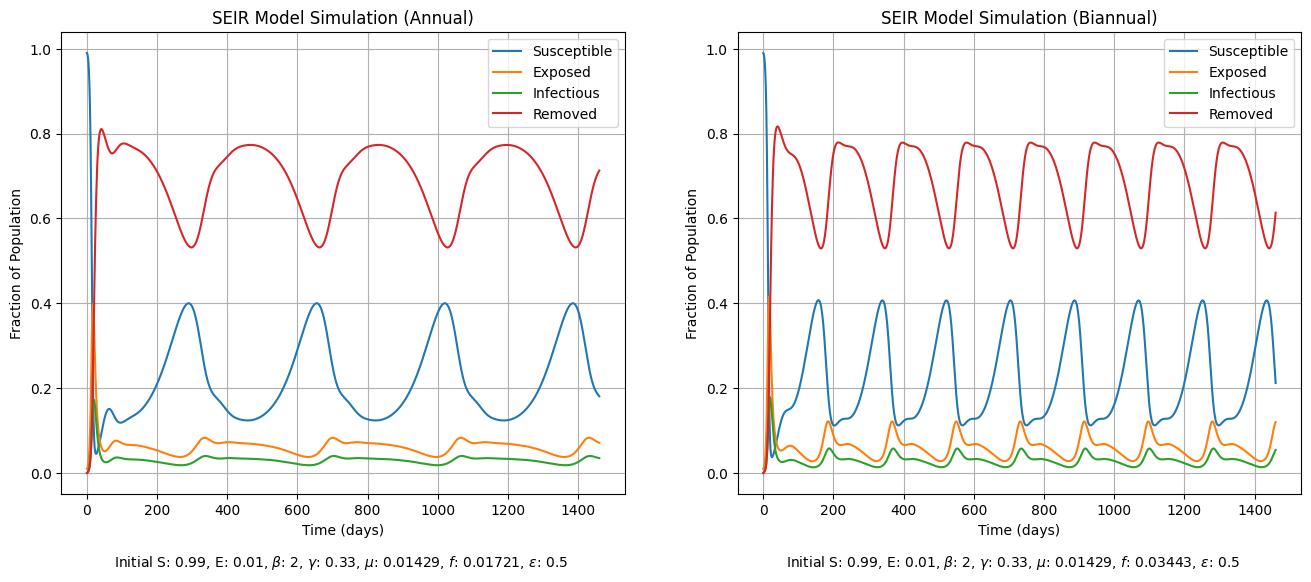

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the results
ax1.plot(sol_seasonal.t, sol_seasonal.y[0], label='Susceptible')
ax1.plot(sol_seasonal.t, sol_seasonal.y[1], label='Exposed')
ax1.plot(sol_seasonal.t, sol_seasonal.y[2], label='Infectious')
ax1.plot(sol_seasonal.t, sol_seasonal.y[3], label='Removed')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Fraction of Population')
ax1.legend()
ax1.set_title('SEIR Model Simulation (Annual)')
ax1.grid(True)

ax2.plot(sol_seasonal2.t, sol_seasonal2.y[0], label='Susceptible')
ax2.plot(sol_seasonal2.t, sol_seasonal2.y[1], label='Exposed')
ax2.plot(sol_seasonal2.t, sol_seasonal2.y[2], label='Infectious')
ax2.plot(sol_seasonal2.t, sol_seasonal2.y[3], label='Removed')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Fraction of Population')
ax2.legend()
ax2.set_title('SEIR Model Simulation (Biannual)')
ax2.grid(True)

# Add figtexts below the subplots
fig.text(0.30, -0.02, fr'Initial S: {round((S0), 5)}, E: {round((E0), 5)}, $\beta$: {round((beta), 2)}, $\gamma$: {round((gamma), 2)}, $\mu$: {round(mu, 5)}, $f$: {round(freq, 5)}, $\epsilon$: 0.5', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')

fig.text(0.72, -0.02, fr'Initial S: {round((S0), 5)}, E: {round((E0), 5)}, $\beta$: {round((beta), 2)}, $\gamma$: {round((gamma), 2)}, $\mu$: {round(mu, 5)}, $f$: {round(freq2, 5)}, $\epsilon$: 0.5', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')

plt.show()